# Matched Filter

This notebook will apply a matched filter to either a single pixel or the average of a selected area for the given datacube `.nc` file.

In [252]:
from spectral import *
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pickle as pk
import os
from matplotlib import cm

In [308]:
from_path = "processed-data/bedford-capture/capture-1/reflectance/2023_03_14/"

dir_cont = os.listdir(from_path)

data_cubes = [cont for cont in dir_cont if '.nc' in cont]

data_cubes = sorted(data_cubes)

cubes = []

for i in range(len(data_cubes)):    
    # capture every second item for sardi
    # if i%2 == 1:
    #     cubes.append(data_cubes[i])
    cubes.append(data_cubes[i])

print(cubes)

['2023_03_14-01_26_05.nc', '2023_03_14-01_39_32.nc', '2023_03_14-01_40_47.nc', '2023_03_14-01_42_06.nc', '2023_03_14-01_43_21.nc', '2023_03_14-01_44_34.nc', '2023_03_14-01_46_01.nc', '2023_03_14-01_48_23.nc', '2023_03_14-01_49_45.nc', '2023_03_14-01_51_20.nc', '2023_03_14-01_53_14.nc', '2023_03_14-01_55_01.nc', '2023_03_14-01_56_42.nc', '2023_03_14-01_58_25.nc', '2023_03_14-02_00_05.nc', '2023_03_14-02_01_40.nc', '2023_03_14-02_03_31.nc', '2023_03_14-02_05_38.nc', '2023_03_14-02_07_19.nc', '2023_03_14-02_08_44.nc']


In [319]:
file = "2023_03_14-02_01_40"
path = "evaluations/bedford/spectra/underwater/"
base = path + file

In [320]:
# get files for this work
fn = from_path+file+".nc"
png_fn = fn.split('.')[0] + ".png"

In [321]:
# Load data
ds = nc.Dataset(fn)

In [322]:
# extract the datacube from the dataset
dc = np.array(ds['datacube'])

In [323]:
# Data needs to be x, y, bands instead of bands, x, y.
data = dc.transpose(1,2,0)

In [324]:
def process_into_rgb(loc_ds):
    """
    Processes a given dataset into an rgb image for display
    """
    loc_dc = np.array(loc_ds['datacube'])
    loc_binned_wavelengths = np.array(loc_ds['wavelength'])
    loc_image = np.zeros((loc_dc.shape[1],loc_dc.shape[2],3), np.uint8)

    loc_red_wavelength = 620
    loc_green_wavelength = 570
    loc_blue_wavelength = 450

    loc_red_layer = loc_dc[np.argmin(np.abs(loc_binned_wavelengths-loc_red_wavelength)),:,:]  
    loc_green_layer = loc_dc[np.argmin(np.abs(loc_binned_wavelengths-loc_green_wavelength)),:,:] 
    loc_blue_layer = loc_dc[np.argmin(np.abs(loc_binned_wavelengths-loc_blue_wavelength)),:,:] 

    # loc_red_layer = loc_dc[120,:,:]  
    # loc_green_layer = loc_dc[80,:,:] 
    # loc_blue_layer = loc_dc[20,:,:] 

    loc_image[:,:,0] = loc_red_layer
    loc_image[:,:,1] = loc_green_layer
    loc_image[:,:,2] = loc_blue_layer

    # scale the values to within the central 2 to 98 percent values to remove outlier readings
    loc_vmax = np.nanpercentile(loc_image, 98)
    loc_vmin = np.nanpercentile(loc_image, 2)
    loc_image = ((loc_image.astype("f8") - loc_vmin) / (loc_vmax - loc_vmin)).astype("f4")
    loc_image = np.minimum(np.maximum(loc_image, 0), 1)

    loc_image *= 255
    loc_image = loc_image.astype(np.uint8)
    
    return loc_image

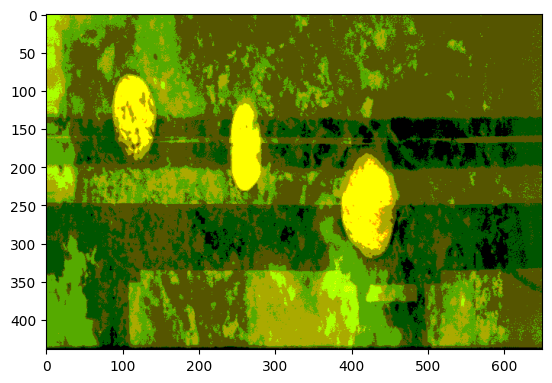

In [325]:
image = process_into_rgb(nc.Dataset(fn.replace('reflectance','radiance')))
# image = plt.imread(png_fn)
plt.imshow(image)

In [326]:
plt.imsave(base+'_original.png', image)

In [327]:
bands = {}

In [328]:
sample_img = image.copy()

In [360]:
# background
# rock
# light_algae
# dark_algae

band = 'dark_algae'

In [361]:
# let the user select an area to average and match

# Select ROI
r = cv.selectROI("select roi", image)

# close the window
cv.destroyAllWindows()

# Crop hsi image
cropped = dc[:,int(r[1]):int(r[1]+r[3]),int(r[0]):int(r[0]+r[2])]

#                         src, startpoint, endpoint, colour, thickness
sample_img = cv.rectangle(sample_img, (int(r[0]),int(r[1])), (int(r[0]+r[2]),int(r[1]+r[3])), (255,27,27), 1)

# take mean of sample area
pixel = np.mean(cropped.reshape(cropped.shape[0], cropped.shape[1]*cropped.shape[2]),1)

In [362]:
# filter the image and match on the chosen pixel
matched = matched_filter(data, pixel)

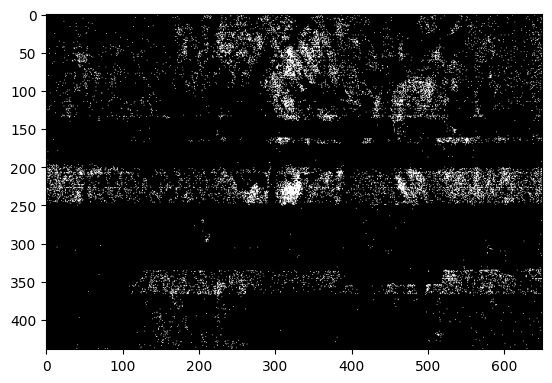

In [363]:
# view the matches from the single pixel
matched_img = 1 * (matched > 0.6)
v = imshow(matched_img)

In [364]:
plt.imsave(base+'_'+band+'_mf.png', matched_img)

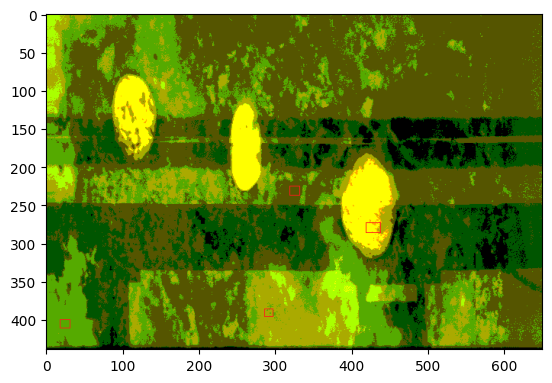

In [365]:
plt.imshow(sample_img)

In [366]:
plt.imsave(base+'_'+band+'_loc.png', sample_img)

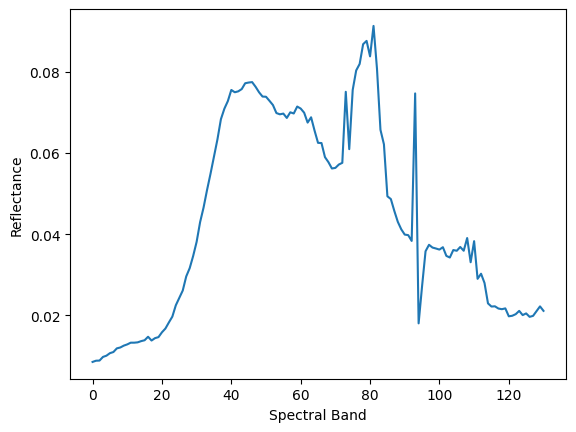

In [367]:
plt.figure()
plt.plot(pixel)
plt.xlabel('Spectral Band')
plt.ylabel('Reflectance')
plt.savefig(base+'_'+band+'.png')
plt.show()

In [368]:
with open(base+'_'+band+'.pkl', 'wb') as out_file:
    pk.dump(pixel, out_file)

In [369]:
bands[band] = pixel

## Combined Plot

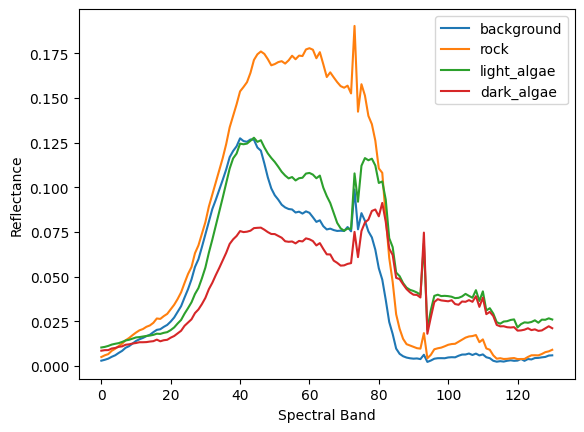

In [370]:
plt.figure()
for name,band in bands.items():
    plt.plot(band, label=name)
plt.xlabel('Spectral Band')
plt.ylabel('Reflectance')
plt.legend()
plt.savefig(base+'_combined.png')
plt.show()

## Comparing across images

In [221]:
spec_path = "evaluations/initial/spectra"

dir_cont = os.listdir(spec_path)

dir_pkls = [cont for cont in dir_cont if '.pkl' in cont]

spectra = {}

name = 'plant_pebbles'

for i in range(len(dir_pkls)):  
    if name in dir_pkls[i]:
        print(spec_path+'/'+dir_pkls[i])
        with open(spec_path+'/'+dir_pkls[i], 'rb') as in_file:
            spectra[dir_pkls[i].split('_'+name)[0]]=pk.load(in_file)

evaluations/initial/spectra/2022_11_16-04_01_51_plant_pebbles.pkl
evaluations/initial/spectra/2022_11_16-04_04_28_plant_pebbles.pkl
evaluations/initial/spectra/2022_11_16-04_03_31_plant_pebbles.pkl
evaluations/initial/spectra/2022_11_16-04_02_46_plant_pebbles.pkl


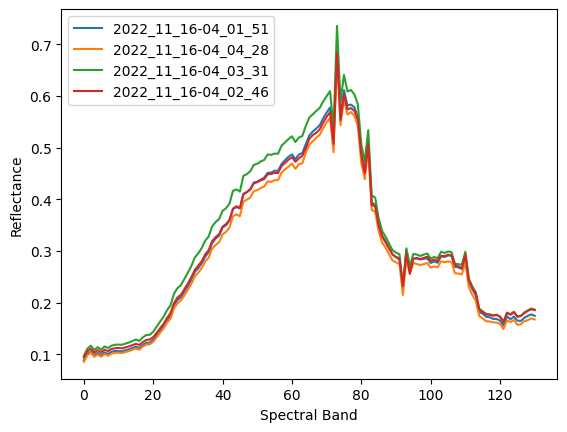

In [222]:
plt.figure()
for n,spec in spectra.items():
    plt.plot(spec, label=n)
plt.xlabel('Spectral Band')
plt.ylabel('Reflectance')
plt.legend()
plt.savefig(spec_path+'/all_'+n+'_'+name+'_comp.png')
plt.show()